In [23]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

from gsw import IPV_vs_fNsquared_ratio, f, Nsquared

In [2]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

In [13]:
# coriolis = f(ctd['lat'][:])

SA = ctd['SA'][:]
CT = ctd['CT'][:]
p = ctd['p'][:]
lat = ctd['lat'][:, 0]
p_ref = 1494

IPV_N2, p_mid = IPV_vs_fNsquared_ratio(SA, CT, p, p_ref=p_ref, axis=1)
N2 = Nsquared(SA, CT, p, lat, axis=1,)[0]

IPV = IPV_N2 * N2



(101, 762)

In [17]:
pressure_levels = {}
for ip, p in enumerate(p_mid[0].data):
    pressure_levels[p] = ip

In [35]:
p_int = 401 #dbar
lon = ctd['lon'][:, 0]
ip = pressure_levels[p_int]

# interesting structure of potential vorticity between pressure levels, especially in north of the trough and crest, but shouldn't this be done between neutral surfaces / NSPV (McDougall, 1988)

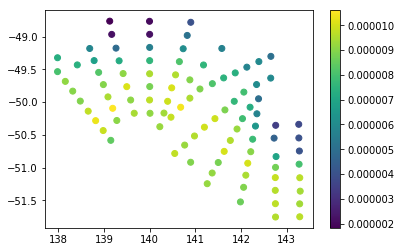

In [49]:
fig, ax = plt.subplots()
scat = ax.scatter(lon[2:], lat[2:], c=np.mean(IPV[2:, pressure_levels[201]:pressure_levels[601]], axis=1), 
                  )
plt.colorbar(scat)

In [47]:
np.mean(IPV[2:, pressure_levels[201]:pressure_levels[601]], axis=1).shape

(99,)